# VGG

In [4]:
import numpy as np

from tqdm.notebook import tqdm

import torch
from torchvision import datasets, transforms

import torch.nn as nn # Defines a series of classes to implement neural nets
import torch.nn.functional as F # Contains functions that are used in network layers

from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import sys
 
# adding Folder_2 to the system path
sys.path.insert(0, '../Scripts')

---
## Load CIFAR10

In [5]:
def load_dataset(batch_size :int = 16, data_dir: str = './'):
    
    train_transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                         ]
                                        )
    
    test_transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        ]
                                       )
    

    train_dataset = datasets.CIFAR10(root=data_dir,
                                     train=True,
                                     download=True,
                                     transform=train_transform)
    
    test_dataset = datasets.CIFAR10(root=data_dir,
                                     train=False,
                                     download=True,
                                     transform=test_transform)
    
    print(f"Train dataset:\n{train_dataset}")
    print(f"Test dataset:\n{test_dataset}")
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_dataset(batch_size=16, data_dir = '../Data')

Files already downloaded and verified
Files already downloaded and verified
Train dataset:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Test dataset:
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


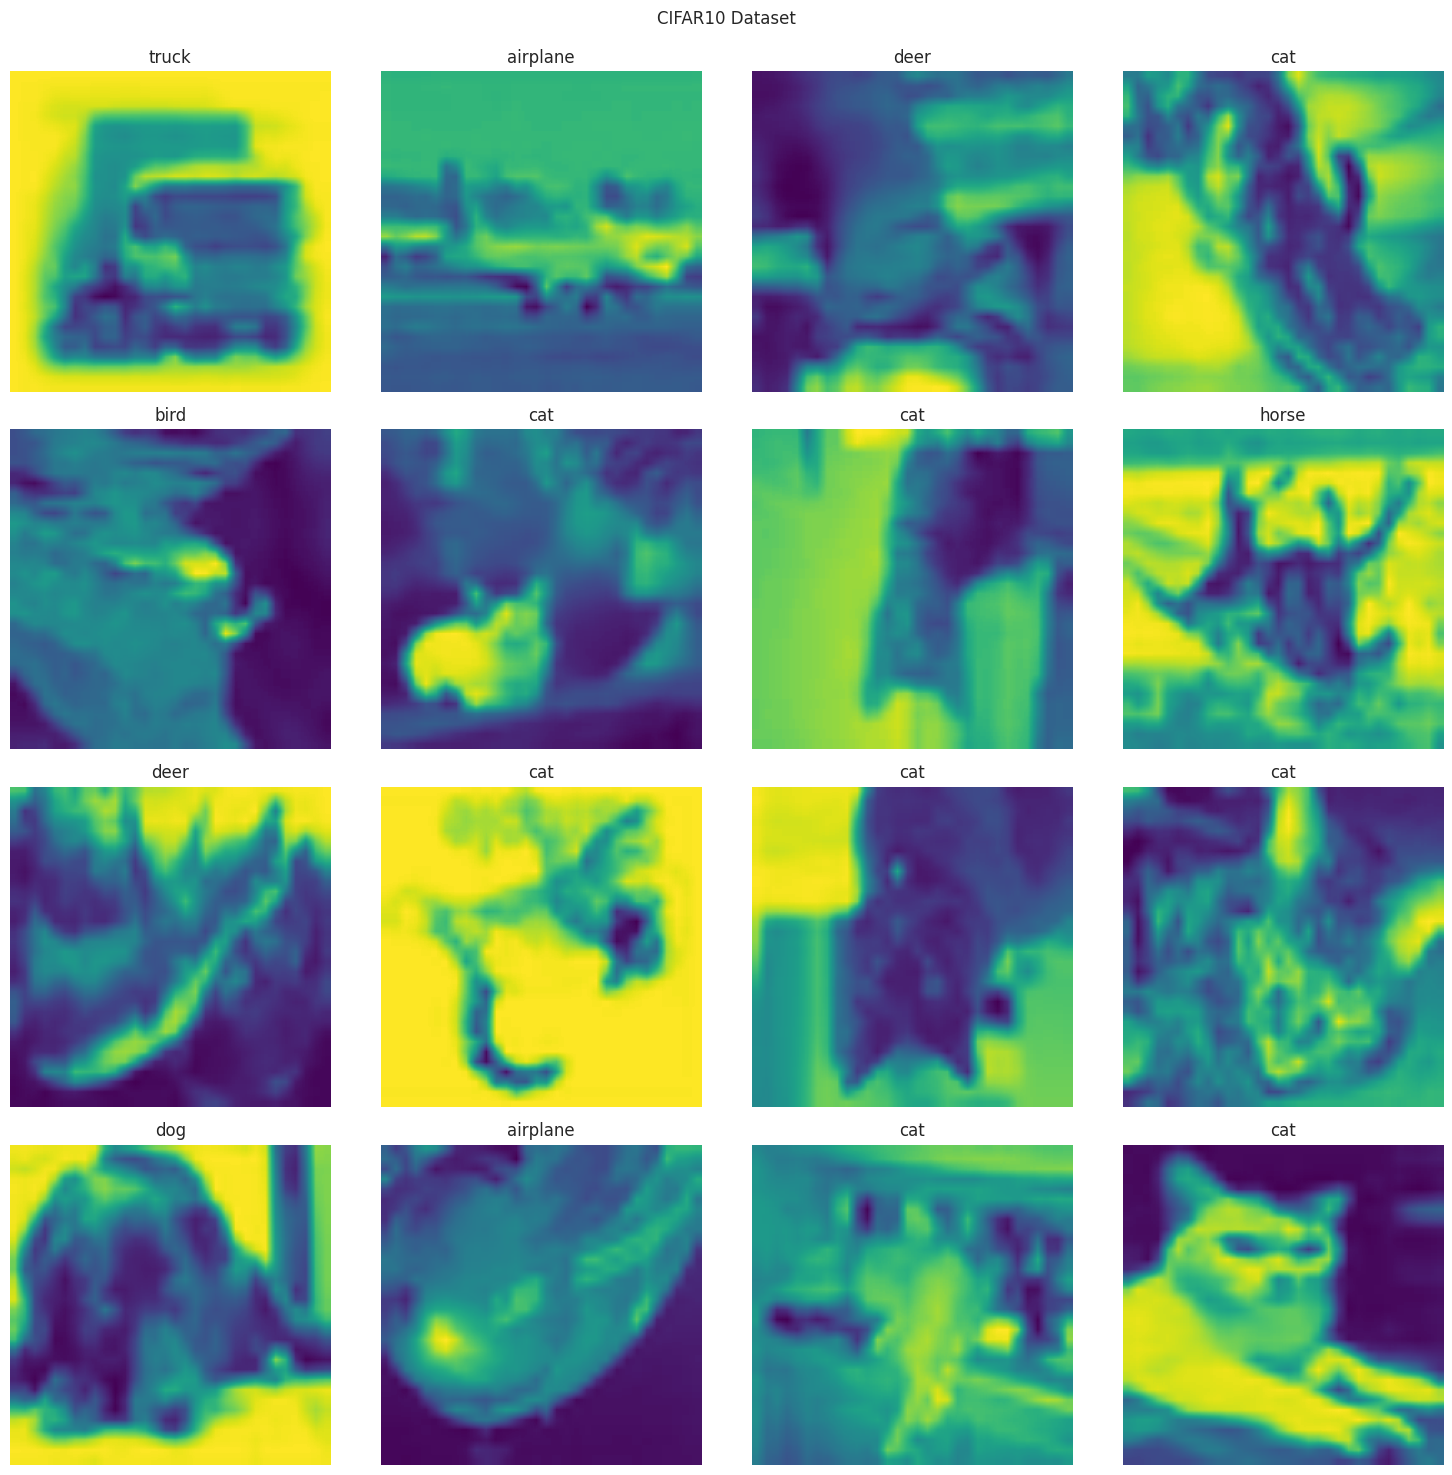

In [7]:
def show_batch(data: DataLoader, mapping_dict: dict, num_rows: int=4) -> None:
    
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_rows, figsize=(15, 15))
    
    batch = next(iter(data))
    images, labels = batch[0], batch[1]
    current_label = 0
    for row in range(num_rows):
        for column in range(num_rows):
            ax[row, column].imshow(images[num_rows*row + column][0, :, :], cmap='viridis')
            ax[row, column].axis('off')
            
            ax[row, column].set_title(mapping_dict[int(labels[current_label].numpy())])
            current_label += 1
            
    plt.suptitle("CIFAR10 Dataset\n")
    plt.tight_layout()
    plt.show()
    
    
id2class = {0:'airplane',
            1:'automobile',
            2:'bird',
            3:'cat',
            4:'deer',
            5:'dog',
            6:'frog',
            7:'horse',
            8:'ship',
            9:'truck'}

show_batch(train_loader, mapping_dict=id2class)

---
## Model Architecture

In [8]:
class ConvBlock(nn.Module):
    def __init__(self,
                   in_channels:int,
                   out_channels:int,
                   kernel_size:int,
                   stride:int,
                   padding:int,
                   use_max_pool: bool = False,
                   max_pool_kernel_size:int = 2,
                   max_pool_stride:int = 2,
                   ):
        
        super(ConvBlock, self).__init__()
        
        self.__use_max_pool = use_max_pool
        
        if self.__use_max_pool:
            self.block = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=max_pool_stride)
                    )
        else:
            self.block = nn.Sequential(
                                nn.Conv2d(in_channels=in_channels,
                                          out_channels=out_channels,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU()
                            )
              
    
    def forward(self, x):            
        return self.block(x)
        

In [9]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        
        # ConvBlocks
        
        self.block1 = ConvBlock(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.block2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, use_max_pool=True)
        
        self.block3 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.block4 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, use_max_pool=True)
        
        self.block5 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.block6 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.block7 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, use_max_pool=True)
        
        self.block8 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.block9 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.block10 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, use_max_pool=True)
        
        self.block11 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.block12 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.block13 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, use_max_pool=True)
    
        # Fully Connected Head
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=7*7*512, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes)
        )
        
        
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        
        x = x.reshape(x.size(0), -1)
                
        return self.fc(x)
        

In [10]:
vgg16 = VGG(num_classes=10)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
vgg16 = vgg16.to(device)

Device: cpu


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
from torchinfo import summary

summary(model=vgg16, input_size=(1, 3, 224, 224), col_width=30,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape                    Output Shape                   Param #                        Trainable
VGG (VGG)                                [1, 3, 224, 224]               [1, 10]                        --                             True
├─ConvBlock (block1)                     [1, 3, 224, 224]               [1, 64, 224, 224]              --                             True
│    └─Sequential (block)                [1, 3, 224, 224]               [1, 64, 224, 224]              --                             True
│    │    └─Conv2d (0)                   [1, 3, 224, 224]               [1, 64, 224, 224]              1,792                          True
│    │    └─BatchNorm2d (1)              [1, 64, 224, 224]              [1, 64, 224, 224]              128                            True
│    │    └─ReLU (2)                     [1, 64, 224, 224]              [1, 64, 224, 224]              --                             --
├─ConvBlock (block2)    

---
## Model training

In [14]:
def training_setup(learning_rate, model):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)
    return loss, optimizer


loss_module, optimizer = training_setup(learning_rate=5e-3, model=vgg16)

In [12]:
vgg16 = torch.compile(vgg16)

for batch_idx, (images, labels) in enumerate(train_loader):
    vgg16.train()
    images = images.to(device)
    labels = labels.to(device)
    
    break 

outputs = vgg16(images)

In [15]:
from utils import train


history = train(model=vgg16,
                  num_epochs=5,
                  device=device,
                  loss_module=loss_module,
                  optimizer=optimizer,
                  train_loader=train_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

---
## Test metrics

In [13]:
from torchmetrics import Accuracy

test_loss, test_acc = 0, 0

vgg16.to(device)

accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy.to(device)

vgg16.eval()

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = vgg16(X)
        
        test_loss += loss_module(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

Test loss:  1.70472| Test acc:  0.33150
